# DFA attack on AES-128

# Aims

The aim of this notebook is to show an alternative to DPA and CPA by using DFA to recover the secret key of an AES.

# Hardware assembly

This notebook is configure for the STM32F3 target. 

**Summary**
* Identify the last rounds (r8, r9, r10)
* Make faults before MxC r9
* Perform Piret's Attack
* Make faults before MxC r8
* Perform Piret's Attack

In [41]:
SCOPETYPE = "OPENADC"
PLATFORM = 'CW308_STM32F3'
CRYPTO_TARGET = "TINYAES128C"

## Prerequisites

### Brief introduction to Differential Fault Analysis

Each round is composed of 4 operations except for the last, which has no mixing column (this round is smaller than the others).
- Sub-bytes: passe in the S-box
- Shift rows: shifting of tines
- Mix Columns: Mixing of columns
- Add Round Key:  Apply a xor between the intermediate state and the round key.


<img src="https://www.securiteinfo.com/cryptographie/aes.gif" style="width:30%;" />

### Installing dependencies

Firstly, let's install `phoenixAES` in the current kernel environment:

In [42]:
import sys
!{sys.executable} -m pip install phoenixAES

### Building the target firmware

In [43]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../chipwhisperer/firmware/mcu/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CW308_STM32F3 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:14.2.rel1-1) 14.2.1 20241119
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CW308_STM32F3 
.
Compiling:
-en     simpleserial-aes.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Compiling:
-en     .././crypto/tiny-AES128-C/aes.c ...
-e Done!
.
Compiling:
-en     .././crypto/aes-independant.c ..

## Attack setup

### CW-lite connection and target flashing

Connect to the Chipwhisperer:

In [44]:
%run "../chipwhisperer/chipwhisperer-jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


Flash the target:

In [45]:
fw_path = "../chipwhisperer/firmware/mcu/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6083 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6083 bytes


In [46]:
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

### First execution

For the DFA attack, we need a **constant plaintext** (and **constant key** of course).

In [47]:
ktp = cw.ktp.Basic()
ktp.fixed_text = True
ktp.fixed_key = True
key, text = ktp.next()

In [48]:
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 8000

Let's test our setup with a first execution, without fault.
It will give us the **golden reference output**.

In [49]:
# make sure glitches are disabled (in case cells are re-run)
scope.io.hs2 = "clkgen"

trace = cw.capture_trace(scope, target, text, key)
goldciph = trace.textout
master_key = key.hex()
print("Plaintext: {}".format(text.hex()))
print("Key:       {}".format(key.hex()))
print("Ciphertext:{}".format(goldciph.hex()))

Plaintext: 000102030405060708090a0b0c0d0e0f
Key:       2b7e151628aed2a6abf7158809cf4f3c
Ciphertext:50fe67cc996d32b6da0937e99bafec60


In [50]:
reset_target(scope)

In [51]:
from Crypto.Cipher import AES
aes = AES.new(bytes(key), AES.MODE_ECB)
goldciph2 = aes.encrypt(bytes(text))
print("Expected ciphertext:  {}".format(goldciph2.hex()))

Expected ciphertext:  50fe67cc996d32b6da0937e99bafec60


To execute our DFA attack, we need to identify 8th round, 9th round and the 10th round 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
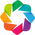

:Overlay
   .Curve.I           :Curve   [x]   (y)
   .Path.A_8th_round  :Path   [x,y]
   .Path.A_9th_round  :Path   [x,y]
   .Path.A_10th_round :Path   [x,y]

In [52]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
curve = hv.Curve(trace.wave).opts(width=600, height=600)


line = hv.Path([(4990, -0.1), (4990, 0.2), (5670, 0.2), (5670, -0.1), (4990, -0.1)], label='8th round').opts(color="red", show_legend=True) * \
            hv.Path([(5670, -0.1), (5670, 0.2), (6330, 0.2), (6330, -0.1), (5670, -0.1)], label='9th round').opts(color="green", show_legend=True) * \
            hv.Path([(6330, -0.1), (6330, 0.2), (6750, 0.2), (6750, -0.1), (6330, -0.1)], label='10th round').opts(color="yellow", show_legend=True)


#plt.show()
(curve * line).opts(opts.Path(line_width=3)).opts(width=600, height=600)

We see clearly the 10 AES-128 rounds, **the 10th round being smaller than the others** as there is no *MixColumn*.

### First glitches

In [53]:
import time

# These width/offset numbers are for CW-Lite/Pro; for CW-Husky, convert as per Fault 1_1:
def test_glitches():
    scope.io.hs2 = "glitch"
    scope.glitch.clk_src = "clkgen"
    scope.glitch.width = -10.15625
    scope.glitch.offset = -13.84
    scope.glitch.trigger_src='continuous'

def stop_test_glitches():
    scope.glitch.trigger_src='ext_single'

test_glitches()
time.sleep(2)
stop_test_glitches()

In [54]:
print(scope.glitch)

clk_src     = clkgen
width       = -10.15625
width_fine  = 0
offset      = -13.671875
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = clock_xor



Let's see the effect of clock glitches on the AES execution.

In [55]:
scope.io.hs2 = "glitch"
scope.glitch.clk_src = "clkgen"
scope.glitch.width = -10.15625 + 1
scope.glitch.offset = -13.84
scope.glitch.ext_offset = 5800 #5400
scope.glitch.repeat = 3
scope.glitch.trigger_src='ext_single'

# reset target
reset_target(scope)
time.sleep(0.1)

trace = cw.capture_trace(scope, target, text, key)

In [18]:
curve = hv.Curve(trace.wave)
#curve *= hv.Path([(scope.glitch.ext_offset, 0.25), (scope.glitch.ext_offset, -0.3)]).opts(color="red")
curve.opts(width=600, height=600)

:Curve   [x]   (y)

You should see a glitch in the power trace (blue) when the clock was glitched (red dotted line).  
<!-- As said earlier, glitch parameters may have to be adapted to your specific hardware.  Our experience is that a good `scope.glitch.width` is one just a bit smaller than one producing a clearly visible glitch in the power trace. E.g. the trace above was created with `scope.glitch.width=6*MIN_STEP` and we'll use `scope.glitch.width=5*MIN_STEP` in our attack. If this is not precise enough, consider tuning `scope.glitch.width_fine` too.-->

### Campaign setup

In [56]:
# get control over logging in order to be able to mask target execution errors,
# which can easily happen when glitching the target!
import logging
import chipwhisperer.common.results.glitch as glitch

# can 
gc = glitch.GlitchController(groups=["column0", "column1", "column2", "column3", "other", "reset", "normal"], parameters=["width", "offset", "ext_offset"])

The next cell defines the glitches campaign.

In [57]:
#check if a single column is glitched
def check_column_glitch(glitched_ct, gold_ct, column):
    column_lookup = [[0, 13, 10, 7], [4, 1, 14, 11], [8, 5, 2, 15], [12, 9, 6, 3]] #shift rows
    for byte in column_lookup[column]:
        if glitched_ct[byte] == gold_ct[byte]:
            return False
    return True

outputs = []
results = []
obf = []
def campaign():
    # Initial glitch parameters
    global outputs
    global results
    global obf
    
    #reset results arrays
    outputs = []
    results = results = [['target output', 'width', 'offset', 'extoffset', 'column_fault']]
    obf = []
    
    #glitch setup
    scope.io.hs2 = "glitch"
    scope.glitch.clk_src = 'clkgen'
    scope.glitch.trigger_src = 'ext_single'
    key, text = ktp.next()
    
    #make sure correct key is loaded on target
    reboot_flush()
    target.simpleserial_write('k', key)
    target.simpleserial_wait_ack()
    
    for glitch_setting in gc.glitch_values():
        # set glitch settings
        scope.glitch.offset = glitch_setting[1]
        scope.glitch.width = glitch_setting[0]
        scope.glitch.ext_offset = glitch_setting[2]
        
        #do glitch
        target.flush()
        key, text = ktp.next()
        logging.getLogger().setLevel(logging.ERROR)
        
        scope.arm()        
        target.simpleserial_write('p', text)
        
        ret = scope.capture()
        if ret:
            print("timeout!")
            reboot_flush()
            target.simpleserial_write('k', key)
            target.simpleserial_wait_ack()
            continue
          
        #record output
        output = target.simpleserial_read_witherrors('r', 16, timeout=100, glitch_timeout=1) #don't care about glitchy text
        
        #handle invalid output
        if not output['valid']:
            gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            reboot_flush()
            target.simpleserial_write('k', key)
            target.simpleserial_wait_ack()
            continue
        
        data = [bytes(output['payload']).hex(), scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset]
        
        #normal output
        if output['payload'] == goldciph:
            gc.add("normal", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            data.append(None)
            results.append(data)
            continue
        
        outputs.append(output['payload'])
        
        #check for a glitch in each column of AES
        column_glitches = []
        for column in range(4):
            if check_column_glitch(output['payload'], goldciph, column):
                column_glitches.append(column)
           
        #We're looking for single column glitches here
        if len(column_glitches) == 1:
            gc.add("column{}".format(column_glitches[0]), (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            obf.append(output['payload'])
            data.append(column_glitches[0])
        else:
            gc.add("other", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            data.append(0xFF)
        
        #for display in ascii table
        results.append(data)        

## Attacking the 9th round

### R9: Collecting faulty outputs

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
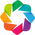

:Overlay
   .Curve.I           :Curve   [x]   (y)
   .Path.A_8th_round  :Path   [x,y]
   .Path.A_9th_round  :Path   [x,y]
   .Path.A_10th_round :Path   [x,y]

In [58]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
curve = hv.Curve(trace.wave).opts(width=600, height=600)

# add boxes around last rounds

line = hv.Path([(4990, -0.1), (4990, 0.2), (5670, 0.2), (5670, -0.1), (4990, -0.1)], label='8th round').opts(color="red", show_legend=True) * \
            hv.Path([(5670, -0.1), (5670, 0.2), (6330, 0.2), (6330, -0.1), (5670, -0.1)], label='9th round').opts(color="green", show_legend=True) * \
            hv.Path([(6330, -0.1), (6330, 0.2), (6750, 0.2), (6750, -0.1), (6330, -0.1)], label='10th round').opts(color="yellow", show_legend=True)


(curve * line).opts(opts.Path(line_width=3)).opts(width=600, height=600)

In [59]:
# Parameters to make fault before MxColumn R9
gc.set_range("width", 3, 4)
gc.set_range("offset", 10, 10)
gc.set_range("ext_offset", 5700, 5900)
gc.set_global_step(0.5)
scope.glitch.repeat = 1

Execute the campaign

In [62]:
gc.display_stats()
campaign()

IntText(value=0, description='column0 count:', disabled=True)

IntText(value=0, description='column1 count:', disabled=True)

IntText(value=0, description='column2 count:', disabled=True)

IntText(value=0, description='column3 count:', disabled=True)

IntText(value=0, description='other count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=3.0, continuous_update=False, description='width setting:', disabled=True, max=4.0, min=3.0,…

FloatSlider(value=10.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, min=1…

FloatSlider(value=5700.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=5900.…

### R9: Cryptanalysis of the faulty outputs

We'll use `phoenixAES` to perform the DFA against the collected ciphertexts.

In [63]:
import phoenixAES
r9=phoenixAES.crack_bytes(outputs, goldciph, encrypt=True, verbose=2)

50fe67f3996d6fb6da9837e9d2afec60: group 3
50fe67f3996d6fb6da9837e9d2afec60: group 3
b3fe6784996d1e4ada35c3e9db48ec60: group None
b3fe6784996d1e4ada35c3e9db48ec60: group None
69ea67cc1e6d3253da094b5d9b8d3460: group None
69ea67cc1e6d3253da094b5d9b8d3460: group None
50fe5dcc997632b6d50937e99bafec82: group 2
50fe5dcc997632b6d50937e99bafec82: group 2
50fe6712996de5b6dab337e9f8afec60: group 3
Round key bytes recovered:
......A8....25....3F....B6......
50fe6712996de5b6dab337e9f8afec60: group 3
38fe67cc996d3287da0942e99b86ec60: group 0
38fe67cc996d3287da0942e99b86ec60: group 0
72fede52995bb4e2e6b70de91cc3ece8: group None
72fede52995bb4e2e6b70de91cc3ece8: group None
50e267ccb56d32b6da0937fa9baffc60: group 1
50e267ccb56d32b6da0937fa9baffc60: group 1
50fe67ef996d76b6dac637e91fafec60: group 3
50fe67ef996d76b6dac637e91fafec60: group 3
50fe042e997633b666c137e903afec1e: group None
50fe042e997633b666c137e903afec1e: group None
617e0698e6d95e8d4ca5f4e78aa4d336: group None
6144068813d9ea8d4c4cf43f11a4613

Once the **last round key is recovered**, you can **revert the AES keyscheduling** and reveal the actual AES

In [27]:
# Print the master key
from chipwhisperer.analyzer.attacks.models.aes.key_schedule import key_schedule_rounds
print("Found master key:", end="")
r9_key = key_schedule_rounds(bytearray.fromhex(r9), 10, 0)
print(''.join("%02x" % x for x in r9_key))
print(f"Master key: {master_key}")

Found master key:2b7e151628aed2a6abf7158809cf4f3c
Master key: 2b7e151628aed2a6abf7158809cf4f3c


### 

## Attacking the 8th round

### R8: Collecting faulty outputs

Focus faults before MixColumn R8

In [35]:
#Change parameters
#gc.set_range("ext_offset", 5050, 5250)
gc.set_range("ext_offset", 5180, 5200)
gc.display_stats()
campaign()

IntText(value=0, description='column0 count:', disabled=True)

IntText(value=0, description='column1 count:', disabled=True)

IntText(value=0, description='column2 count:', disabled=True)

IntText(value=0, description='column3 count:', disabled=True)

IntText(value=0, description='other count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=3.0, continuous_update=False, description='width setting:', disabled=True, max=4.0, min=3.0,…

FloatSlider(value=10.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, min=1…

FloatSlider(value=5180.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=5200.…

### Piret’s attack R-8
In this second attack, we assume the fault was injected *before* the last two *MixColumn* operations.


In [38]:
outputs2=phoenixAES.convert_r8faults_bytes(outputs, goldciph, encrypt=True)
r8=phoenixAES.crack_bytes(outputs2, goldciph, encrypt=True, verbose=2)


35fe67cc996d32f7da096ce99b6cec60: group 0
50e667cca86d32b6da0937c29bafca60: group 1
50fe26cc99e532b6250937e99bafec1d: group 2
50fe6741996d4bb6da5b37e9eaafec60: group 3
33fe67cc996d32ddda094de99bddec60: group 0
503f67ccf96d32b6da0937679baf1c60: group 1
50fe6acc995c32b6bf0937e99bafec96: group 2
50fe67c4996dd0b6dafe37e9c7afec60: group 3
33fe67cc996d32ddda094de99bddec60: group 0
503f67ccf96d32b6da0937679baf1c60: group 1
50fe6acc995c32b6bf0937e99bafec96: group 2
50fe67c4996dd0b6dafe37e9c7afec60: group 3
2bfe67cc996d3299da0903e99b28ec60: group 0
50f767cc316d32b6da0937ab9bafb560: group 1
50fe68cc99cd32b6980937e99bafeca6: group 2
50fe67c3996de3b6da6a37e975afec60: group 3
2bfe67cc996d3299da0903e99b28ec60: group 0
50f767cc316d32b6da0937ab9bafb560: group 1
50fe68cc99cd32b6980937e99bafeca6: group 2
50fe67c3996de3b6da6a37e975afec60: group 3
67fe67cc996d329cda09e9e99bbaec60: group 0
507467ccf66d32b6da09375d9baf9860: group 1
50fefacc995632b6f30937e99bafec9f: group 2
50fe67a0996d93b6da7737e947afec60: 

Once the **last round key is recovered**, you can **revert the AES keyscheduling** and reveal the actual AES

In [39]:
print("Found master key:", end="")
key = key_schedule_rounds(bytearray.fromhex(r8), 10, 0)
print(''.join("%02x" % x for x in key))
print(f"Master key: {master_key}")

Found master key:2b7e151628aed2a6abf7158809cf4f3c
Master key: 2b7e151628aed2a6abf7158809cf4f3c


## The end

Once you're done, clean up the connection to the scope and target.  

In [40]:
scope.dis()
target.dis()